___
# README: Consistency between Kostelka and IDEA datasets

- This notebook compares the information contained in Kostelka and IDEA datasets
- Before running the next cells, please upload the following .csv files to the Files section in Google Colab (left panel)
  - proc-kostelka.csv
  - proc-idea.csv
- The .csv files can be found [here](https://drive.google.com/drive/folders/1-UbPqDkB9ZBFNmAti3Gt936HVUyfNrfh?usp=drive_link).

___

In [ ]:
!pip install linearmodels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

pd.set_option("display.max_columns", None)

# 1. Load and merge datasets

In [ ]:
PATH_TO_KAST = '/content/proc-kostelka.csv'
PATH_TO_IDEA = '/content/proc-idea.csv'

kast = (
          pd.read_csv(PATH_TO_KAST)
          .drop(columns=["CV_Unsanctioned","CV_Sanctioned"])
          .rename(columns={"PLT_COUNTRY":"Country", "EL_TYPE":"type"})
       )

idea = (
          pd.read_csv(PATH_TO_IDEA)
          .rename(columns={"Voter_Turnout":"Turnout"})
       )

idea["type"] = idea["type"].apply(lambda x: "Legislative" if x == "Parliamentary" else x)

tmp_1 = kast.groupby(["year","Country","type"], as_index=False).agg({"CV":"max", "Turnout":"mean"})
tmp_2 = idea.groupby(["year","Country","type"], as_index=False).agg({"CV":"max", "Turnout":"mean", "Population":"max"})

tmp_1["in_kast"] = 1
tmp_2["in_idea"] = 1

print(tmp_1.shape)
tmp_1.head(3)

(1408, 6)


,year,Country,type,CV,Turnout,in_kast
0,1945,Canada,Legislative,0.0,75.3,1
1,1945,Denmark,Legislative,0.0,86.3,1
2,1945,Finland,Legislative,0.0,74.9,1


In [ ]:
print(tmp_2.shape)
tmp_2.head(3)

(3008, 7)


,year,Country,type,CV,Turnout,Population,in_idea
0,1945,Austria,Legislative,0,94.31,6799000,1
1,1945,Brazil,Legislative,1,81.64,46215000,1
2,1945,Brazil,Presidential,1,83.12,46215000,1


In [ ]:
df = (
        pd.merge(
                   tmp_1, tmp_2, how="outer",
                   on=["year","Country","type"],
                   suffixes=["_kast","_idea"]
                )
     )

print(df.shape)
df.head()

(3178, 10)


,year,Country,type,CV_kast,Turnout_kast,in_kast,CV_idea,Turnout_idea,Population,in_idea
0,1945,Canada,Legislative,0.0,75.3,1.0,0.0,76.31,12394000,1.0
1,1945,Denmark,Legislative,0.0,86.3,1.0,0.0,86.29,4045000,1.0
2,1945,Finland,Legislative,0.0,74.9,1.0,0.0,74.87,3758000,1.0
3,1945,Ireland,Presidential,0.0,63.0,1.0,0.0,60.24,2952000,1.0
4,1945,Norway,Legislative,0.0,76.4,1.0,0.0,76.36,3088000,1.0


In [ ]:
df[df["in_idea"]==1].shape

(3008, 10)

In [ ]:
df[df["in_kast"]==1].shape

(1408, 10)

In [ ]:
# Save processed dataset
# ======================

df.to_csv("unified-data-20240723.csv", index=False)

# 2. Comparison

- This section is not needed for our project, but helped us to understand that our approach is in the right direction
- **Remark:** The comparison is based on the records that International IDEA has in common with Kostelka.

In [ ]:
filt_intersection = (df["in_idea"]==1) & (df["in_kast"]==1)
filt_years = (df["year"].between(1945,2017))

**2.1. Discrepancies in CV values**

The differences in CV value may be due to the review of "contemporary and historical documents, legislation, and constitutions to create [...] CV to date" as stated in Kostelka et al's paper.

['Switzerland' 'Austria' 'Cyprus' 'Dominican Republic' 'Panama']

     year             Country          type  CV_idea  CV_kast
865  2002  Dominican Republic   Legislative      1.0     0.00
75   1955         Switzerland   Legislative      1.0     0.34
159  1963         Switzerland   Legislative      1.0     0.35
544  1991         Switzerland   Legislative      0.0     0.07
376  1982  Dominican Republic  Presidential      1.0     0.00

count    1238.000000
mean        0.020226
std         0.155361
min        -0.350000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: diff_cv, dtype: float64



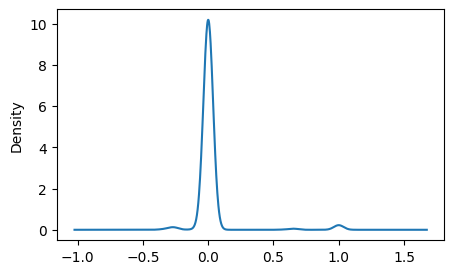

In [ ]:
tmp_3 = df[filt_intersection & filt_years].copy()
tmp_3["diff_cv"] = tmp_3["CV_idea"] - tmp_3["CV_kast"]

filt_no_cv_discrep = (tmp_3["CV_idea"] == tmp_3["CV_kast"])

print(tmp_3[~filt_no_cv_discrep]["Country"].unique())
print()
print(tmp_3.loc[~filt_no_cv_discrep, ["year","Country","type","CV_idea","CV_kast"]].sample(5))
print()
print(tmp_3["diff_cv"].describe().T)
print()

plt.figure(figsize=(5,3))
(tmp_3["diff_cv"]).plot.kde();

**2.2. Discrepancies in turnout**

      year        Country          type  Turnout_idea  Turnout_kast
1158  2010  United States   Legislative         48.59          41.0
475   1988  United States  Presidential         86.20          52.8
352   1980           Peru   Legislative         80.44          71.1
755   1998  United States   Legislative         51.55          38.1
944   2004    Philippines  Presidential         76.97          84.1

count    1238.000000
mean        1.469562
std         4.359133
min         0.000000
25%         0.020000
50%         0.040000
75%         0.687500
max        34.400000
Name: diff_to, dtype: float64



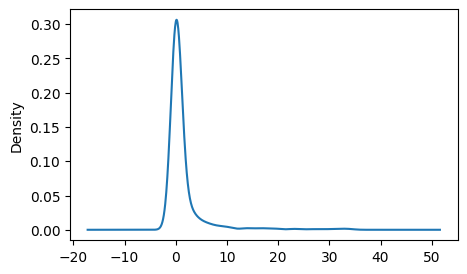

In [ ]:
tmp_4 = df[filt_intersection & filt_years].copy()
tmp_4["diff_to"] = (tmp_4["Turnout_idea"] - tmp_4["Turnout_kast"]).abs()

filt_no_to_discrep = (tmp_4["diff_to"] < 3)

print(tmp_4.loc[~filt_no_to_discrep, ["year","Country","type","Turnout_idea","Turnout_kast"]].sample(5))
print()
print(tmp_4["diff_to"].describe().T)
print()

plt.figure(figsize=(5,3))
tmp_4["diff_to"].plot.kde();

2.3. Discrepancies in regression analysis (baseline)

In [ ]:
# Using Kastelka
# ==============
tmp_5 = df[filt_intersection & filt_years].copy()
tmp_5.set_index(["Country","year"], inplace=True)

formula = 'Turnout_kast ~ 1 + CV_kast'
model_fe = PanelOLS.from_formula(formula, data=tmp_5, drop_absorbed=True)
fe_res = model_fe.fit(cov_type='clustered', cluster_entity=True)

fe_res.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,68.724,1.5450,44.481,0.0000,65.693,71.755
CV_kast,12.454,2.5252,4.9319,0.0000,7.4997,17.408


In [ ]:
# Using IDEA
# ==========
tmp_5 = df[filt_intersection & filt_years].copy()
tmp_5.set_index(["Country","year"], inplace=True)

formula = 'Turnout_idea ~ 1 + CV_idea'
model_fe = PanelOLS.from_formula(formula, data=tmp_5, drop_absorbed=True)
fe_res = model_fe.fit(cov_type='clustered', cluster_entity=True)

fe_res.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,67.880,1.6489,41.167,0.0000,64.645,71.115
CV_idea,14.492,2.7032,5.3610,0.0000,9.1885,19.795


2.4. Discrepancies in regression analysis (among non-discrepant records)

In [ ]:
tmp_5 = df[filt_intersection & filt_years].copy()
tmp_5["diff_to"] = (tmp_5["Turnout_idea"] - tmp_5["Turnout_kast"]).abs()

filt_cv = (tmp_5["CV_idea"] == tmp_5["CV_kast"])
filt_to = (tmp_5["diff_to"] < 3)

tmp_6 = tmp_5[filt_cv & filt_to].copy()
tmp_6.set_index(["Country","year"], inplace=True)

formula = 'Turnout_kast ~ 1 + CV_kast'
model_fe = PanelOLS.from_formula(formula, data=tmp_6, drop_absorbed=True)
fe_res = model_fe.fit(cov_type='clustered', cluster_entity=True)

fe_res.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,68.742,1.5581,44.118,0.0000,65.685,71.800
CV_kast,14.085,2.6695,5.2763,0.0000,8.8468,19.323
